In [ ]:
#!pip install qiskit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.quantum_info import Pauli
from qiskit import IBMQ, QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
%matplotlib inline

In [2]:
n=4

cost_obs_matrix=np.zeros((2**n,2**n),dtype="complex128")
for i in range(n):
    z=[False]*n
    z[i]=True
    z[(i+1)%n]=True
    cost_obs_matrix += Pauli(np.flip(z),[False]*n).to_matrix() * 0.5

In [3]:
def add_U_C(circuit,gamma):
    for i in range(n):
        j = (i+1) % n
        circuit.cx(i,j)
        circuit.rz(2*gamma,j)
        circuit.cx(i,j)
    return circuit

def add_U_X(circuit,beta):
    for i in range(n):
        circuit.rx(2*beta,i)
    return circuit

def QAOA_output_twolayer(x):
    beta0, beta1, gamma0, gamma1 = x
    
    circuit = QuantumCircuit(n)
    
    for i in range(n):
        circuit.h(i)

    circuit =  add_U_C(circuit,gamma0)
    circuit =  add_U_X(circuit,beta0)
    circuit =  add_U_C(circuit,gamma1)
    circuit =  add_U_X(circuit,beta1)
       
    backend=Aer.get_backend("statevector_simulator")
    state=execute(circuit,backend).result().get_statevector()
    cost=np.dot(state.conj(),np.dot(cost_obs_matrix,state))
    return np.real(cost)

x0=np.array([0.1,0.1,0.2,0.3])

result = minimize(QAOA_output_twolayer, x0, options={'maxiter':500}, method='powell')
print(result.fun)
print(result.x)

-1.99999962236523
[1.01150163 1.11872823 0.45213228 0.55937865]


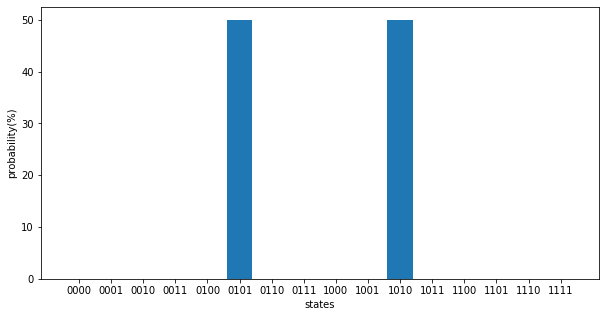

In [4]:
beta0, beta1, gamma0, gamma1 = result.x

circuit = QuantumCircuit(n)

for i in range(n):
    circuit.h(i)
circuit =  add_U_C(circuit,gamma0)
circuit =  add_U_X(circuit,beta0)
circuit =  add_U_C(circuit,gamma1)
circuit =  add_U_X(circuit,beta1)

backend=Aer.get_backend("statevector_simulator")
state=execute(circuit,backend).result().get_statevector()

probs=np.abs(state)**2

z_basis = [format(i,"b").zfill(n) for i in range(probs.size)]
plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis, probs*100)
plt.show()

実機で上のセルと同様の計算をする

In [5]:
IBMQ.save_account("Your Token Here",overwrite=True) # Replace "Your Token Here" to your token

In [6]:
provider=IBMQ.load_account()

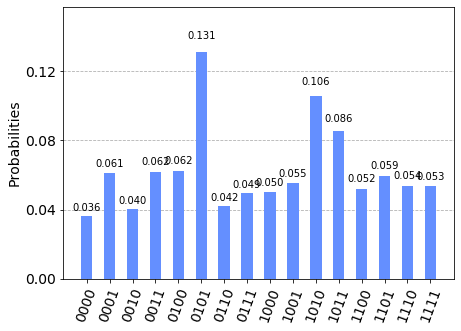

In [7]:
circuit = QuantumCircuit(n,n) # classical register を追加

for i in range(n):
    circuit.h(i)
circuit =  add_U_C(circuit,gamma0)
circuit =  add_U_X(circuit,beta0)
circuit =  add_U_C(circuit,gamma1)
circuit =  add_U_X(circuit,beta1)

for i in range(n):
    circuit.measure(i,i)

backend=provider.get_backend("ibmq_ourense")
counts=execute(circuit,backend,shots=8192).result().get_counts(circuit)
plot_histogram(counts)